In [330]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy,copy
import random
import math
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools
import seaborn as sn
from sklearn.metrics import f1_score

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

## Question 1

In [331]:
def pattern_generator(pattern_size,pattern_number):
    temp=[]
    for h in range(pattern_number):
        y = np.zeros((pattern_size,pattern_size),dtype=float)
        for i in range(pattern_size):
            for j in range(pattern_size):
                x= random.choice([-1,1])
                y[i][j]= x
        temp.append(y)        
    return temp

def perturb_pattern(array,n): 
    temp=random.sample(range(len(array)**2),n)
    for x in temp:
        j=x%len(array) 
        i=int(x/len(array))
        array[i][j]=-array[i][j]
    return array

#Code taken from Prof.Nisheeth Srivastava.
    
def reverse_ind(idx,size):
    return int((idx/size)),(idx%size)
    
def ns_weights(pattern_list,pattern_size):
    weights=np.array([[0]*pattern_size**2]*pattern_size**2)
    for p in range(len(pattern_list)):
        for i in range(pattern_size**2):
            i1,j1=reverse_ind(i,pattern_size)
            for j in range(pattern_size**2):
                i2,j2=reverse_ind(j,pattern_size)
                weights[i][j]+=pattern_list[p][i1][j1]*pattern_list[p][i2][j2]
    return weights/pattern_size**2

def ns_evolution(state,weights):
    pattern_size=len(state)
    tempcopy=deepcopy(state)
    for i in range(pattern_size**2):
        temp=0
        for j in range(pattern_size**2):
            temp+=weights[i][j]*tempcopy[reverse_ind(j,pattern_size)]
        ihat,jhat=reverse_ind(i,pattern_size)
        tempcopy[ihat][jhat]=np.sign(np.sum(temp))
    return tempcopy

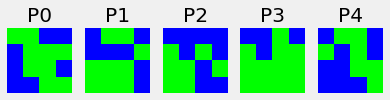

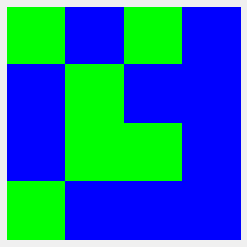

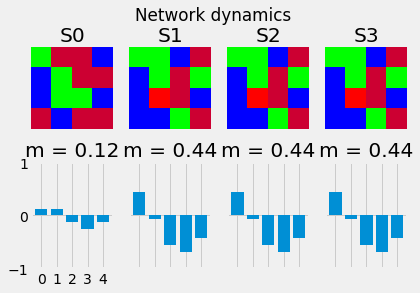

In [332]:
plist = pattern_generator(4,5)

S = perturb_pattern(cue[0],3)
wghts1 = ns_weights(plist,4)
state_list1 =[S]

for i in range(3):
    state_list1.append(ns_evolution(S,wghts1))

plot_tools.plot_pattern_list(plist)
plot_tools.plot_pattern(state_list1[0])
plot_tools.plot_state_sequence_and_overlap(state_list1, plist, reference_idx=0, suptitle="Network dynamics")

## Question 2

In [333]:
def check_accuracy(state,ref):
    acc=0
    for i in range(len(state)):
        for j in range(len(state)):
            if state[i][j]==ref[i][j]:
                acc+=1
            else:
                acc-=1
    return acc/len(state)**2

### Cue informativeness

Text(0, 0.5, 'Accuracy')

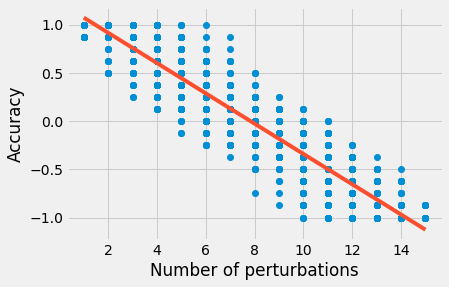

In [334]:
plist = pattern_generator(4,5)
wghts = ns_weights(plist,4)
  
pert_list=[]
acc_list=[]
for x in range(100):
    for i in range(1,16):
        temp=deepcopy(plist[0])
        S=(perturb_pattern(temp,i))

        state_list =[S]
        for j in range(3):
            state_list.append(ns_evolution(S,wghts))
        
        acc=check_accuracy(state_list[2],plist[0])
    
    
        pert_list.append(i)
        acc_list.append(acc)
        
plt.plot(pert_list,acc_list,'o')
plt.plot(np.unique(pert_list), np.poly1d(np.polyfit(pert_list, acc_list, 1))(np.unique(pert_list)))
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')

### Number of patterns

Text(0, 0.5, 'Accuracy')

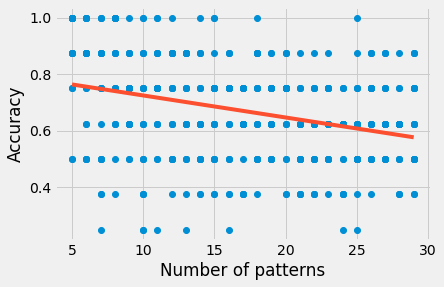

In [335]:
pat_list=[]
acc_list=[]
for x in range(20):
    for i in range(5,30):
        plist = pattern_generator(4,i)
        wghts = ns_weights(plist,4)
        temp=deepcopy(plist[0])
        S=(perturb_pattern(temp,3))

        state_list =[S]
        for j in range(3):
            state_list.append(ns_evolution(S,wghts))
        
        acc=check_accuracy(state_list[2],plist[0])
    
        pat_list.append(i)
        acc_list.append(acc)
    
plt.plot(pat_list,acc_list,'o')
plt.plot(np.unique(pat_list), np.poly1d(np.polyfit(pat_list, acc_list, 1))(np.unique(pat_list)))
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')

### Size of network

Text(0, 0.5, 'Accuracy')

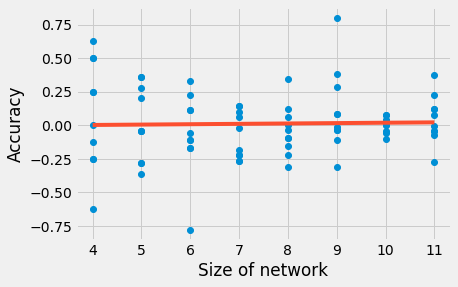

In [336]:
size_list=[]
acc_list=[]
for x in range(10):
    for i in range(4,12):
        plist = pattern_generator(i,5)
        wghts = ns_weights(plist,i)
        temp=deepcopy(plist[0])
        S=perturb_pattern(temp,int(0.5*(i**2)))

        state_list =[S]
        for j in range(3):
            state_list.append(ns_evolution(S,wghts))
        
        acc=check_accuracy(state_list[2],plist[0])
    
        size_list.append(i)
        acc_list.append(acc)

plt.plot(size_list,acc_list,'o')
plt.plot(np.unique(size_list), np.poly1d(np.polyfit(size_list, acc_list, 1))(np.unique(size_list)))
plt.xlabel('Size of network')
plt.ylabel('Accuracy')

### Hopfield MNIST classifier 

Belyaev & Velichko's(2020) model has been used to structure the classifier.

In [337]:
import mnist
import scipy.misc

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

images1 = mnist.train_images()
mnist_list1 = images1.reshape((images1.shape[0], images1.shape[1] * images1.shape[2]))
images2 = mnist.test_images()
mnist_list2=images2.reshape((images2.shape[0], images2.shape[1] * images2.shape[2]))


### Training

Deskewing the images, code has been taken from https://fsix.github.io/mnist/Deskewing.html (Ghosh & Wan, 2021) 

In [338]:
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [339]:
train_list=[]
for i in range(len(mnist_list1)):
    train_list.append(0)
    train_list[i]=deskew(mnist_list1[i].reshape(28,28))
    train_list[i]=train_list[i].astype('float64')
    
test_list=[]
for i in range(len(mnist_list2)):
    test_list.append(0)
    test_list[i]=deskew(mnist_list2[i].reshape(28,28))
    test_list[i]=test_list[i].astype('float64')

In [341]:
#Averaging the training images by class(digit) to use as patterns in the classifier
zero_list,one_list,two_list,three_list,four_list,five_list,six_list,seven_list,eight_list,nine_list = ([] for i in range(10))
numbers=[zero_list,one_list,two_list,three_list,four_list,five_list,six_list,seven_list,eight_list,nine_list]
digits=[0,1,2,3,4,5,6,7,8,9]
for i in range(len(train_list)):
    for d in digits:
        if train_labels[i]==d:
            numbers[d].append(train_list[i]) 
plist=[]
for num in numbers:
    plist.append(np.mean(num,axis=0))

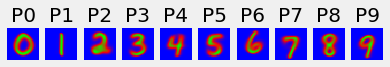

In [342]:
plot_tools.plot_pattern_list(plist)

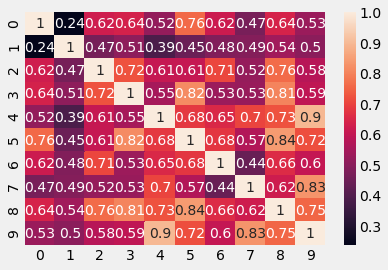

In [343]:
#To check for correlation between averaged images
data = {'0': plist[0].flatten(),
        '1': plist[1].flatten(),
        '2': plist[2].flatten(),
        '3': plist[3].flatten(),
        '4': plist[4].flatten(),
        '5': plist[5].flatten(),
        '6': plist[6].flatten(),
        '7': plist[7].flatten(),
        '8': plist[8].flatten(),
        '9': plist[9].flatten()
        }

df = pd.DataFrame(data,columns=['0','1','2','3','4','5','6','7','8','9'])
#print(df)

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#### Finding the ideal threshold for binarisation and cropping of images to maximise accuracy

In [344]:
def acc_calc(n,pth,tth,start,end):
    
    pcopy=deepcopy(plist)
    tcopy=deepcopy(test_list)
    for i in range(len(pcopy)):
        pcopy[i]=crop_center(pcopy[i],n,n)
    for i in range(len(tcopy)):
        tcopy[i]=crop_center(tcopy[i],n,n)
    
    for array in pcopy:
        for i in range(len(pcopy[0])):
            for j in range(len(pcopy[0])):
                if array[i][j]<=pth: 
                    array[i][j]=-1
                else:
                    array[i][j]=1
    
    for array in tcopy:
        for i in range(len(tcopy[0])):
            for j in range(len(tcopy[0])):
                if array[i][j]<=tth:  
                    array[i][j]=-1
                else:
                    array[i][j]=1
    
    wghts = ns_weights(pcopy,n)
    tp=0
    fp=0
    for i in range(2000,2100):
        S = tcopy[i]
        state_list =[S]

        for j in range(3):
            state_list.append(ns_evolution(S,wghts))

        correct,recog,acc=check_rec_accuracy(state_list[2],pcopy,i)
        actual.append(correct)
        predicted.append(recog)
        if correct==recog:
            tp+=1
        else:
            fp+=1
                

    f_score=tp/(tp+fp)
    print('No of neurons=',n,'Pattern threshold=',pth,'Test images threshold=',tth,'F_score=',f_score)
    return n,pth,tth,f_score

In [345]:
def check_rec_accuracy(state,plist,num):
    acc_list=[]
    for p in plist:
        acc=0
        for i in range(len(state)):
            for j in range(len(state)):
                if state[i][j]==p[i][j]:
                    acc+=1
                else:
                    acc-=1
        acc_list.append(acc)

    correct=test_labels[num]
    sel=max(acc_list)
    selected_num=acc_list.index(sel)
    selected_acc=(sel/len(state)**2)
    return(correct,selected_num,selected_acc)

In [346]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

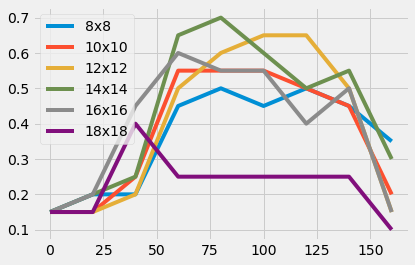

In [157]:
#Used in analysis at test_images_binarization_threshold=36, the code for the graph has been omitted due to redundancy.
crp=np.array(crop)
total_f_1=np.array(total_f)
plt.plot(pth,total_f_1[0:9],label='8x8')
plt.plot(pth,total_f_1[9:18],label='10x10')
plt.plot(pth,total_f_1[18:27],label='12x12')
plt.plot(pth,total_f_1[27:36],label='14x14')
plt.plot(pth,total_f_1[36:45],label='16x16')
plt.plot(pth,total_f_1[45:54],label='18x18')
plt.legend();

In [ ]:
#Finding the ideal combination of threshold parameters.
#Don't run this, it will take forever.The values can be viewed in the next cell.

pth=[20,40,60,80,100,120,140,160]
crop=[8,10,12,14,16,18]
total_f=[]
c_list=[]
p_list=[]
t_list=[]

for cr in crop:
    pcopy=deepcopy(plist)
    tcopy=deepcopy(test_list)
    for i in range(len(plist)):
        pcopy[i]=crop_center(pcopy[i],cr,cr)
    for i in range(len(test_images)):
        tcopy[i]=crop_center(tcopy[i],cr,cr)

    for p1 in pth:
        temp_p=deepcopy(pcopy)
        for array in temp_p:
            for i in range(len(temp_p[0])):
                for j in range(len(temp_p[0])):
                    if array[i][j]<=p1:  #86 chosen reference to paper
                        array[i][j]=-1
                    else:
                        array[i][j]=1
                        
        for p2 in pth:
            temp_t=deepcopy(tcopy)
            for array in temp_t:
                for i in range(len(temp_t[0])):
                    for j in range(len(temp_t[0])):
                        if array[i][j]<=p2:  
                            array[i][j]=-1
                        else:
                            array[i][j]=1 
    
            wghts = ns_weights(temp_p,cr)
            tp=0
            fp=0
            for i in range(20):
                S = temp_t[i]
                state_list =[S]

                for j in range(3):
                    state_list.append(ns_evolution(S,wghts))

                correct,recog,acc=check_rec_accuracy(state_list[2],temp_p,i)
                if correct==recog:
                    tp+=1
                else:
                    fp+=1
            

            f_score=tp/(tp+fp)
            total_f.append(f_score)
            c_list.append(cr)
            p_list.append(p1)
            t_list.append(p2)      

In [356]:
parameter

,Number_of_neurons,Pattern_threshold,Images_threshold,F-scores
0,8,20,20,0.25
1,8,20,40,0.20
2,8,20,60,0.15
3,8,20,80,0.15
4,8,20,100,0.15
...,...,...,...,...
379,18,160,80,0.15
380,18,160,100,0.15
381,18,160,120,0.10
382,18,160,140,0.10


In [349]:
#Creating a dataframe to pick the combinations with the highest f-value. 
parameter=pd.DataFrame(
    {'Number_of_neurons': c_list,
     'Pattern_threshold': p_list,
     'Images_threshold': t_list,
     'F-scores': total_f,
    })
parameter[(parameter['F-scores']>0.6)].reset_index(drop=True)

,Number_of_neurons,Pattern_threshold,Images_threshold,F-scores
0,12,80,60,0.65
1,12,80,80,0.65
2,12,80,100,0.65
3,12,80,120,0.65
4,12,100,20,0.65
5,12,100,40,0.65
6,12,100,100,0.65
7,12,120,20,0.65
8,12,120,40,0.65
9,12,120,60,0.65


In [248]:
#Narrowing down the targets using a larger sample size.You can run this if you have the patience.
num=[12,14]
pth=[80,100,120]
tth=[20,40,60,80,100,120,140]
f_num=[]
f_pth=[]
f_tth=[]
f_fsc=[]
for n in num:
    for p in pth:
        for t in tth:
            x1,x2,x3,x4=acc_calc(n,p,t,100,200) 
            f_num.append(x1)
            f_pth.append(x2)
            f_tth.append(x3)
            f_fsc.append(x4)

No of neurons= 12 P threshold= 80 T threshold= 20 F_score= 0.39
No of neurons= 12 P threshold= 80 T threshold= 40 F_score= 0.46
No of neurons= 12 P threshold= 80 T threshold= 60 F_score= 0.43
No of neurons= 12 P threshold= 80 T threshold= 80 F_score= 0.39
No of neurons= 12 P threshold= 80 T threshold= 100 F_score= 0.35
No of neurons= 12 P threshold= 80 T threshold= 120 F_score= 0.35
No of neurons= 12 P threshold= 80 T threshold= 140 F_score= 0.36
No of neurons= 12 P threshold= 100 T threshold= 20 F_score= 0.58
No of neurons= 12 P threshold= 100 T threshold= 40 F_score= 0.57
No of neurons= 12 P threshold= 100 T threshold= 60 F_score= 0.55
No of neurons= 12 P threshold= 100 T threshold= 80 F_score= 0.51
No of neurons= 12 P threshold= 100 T threshold= 100 F_score= 0.47
No of neurons= 12 P threshold= 100 T threshold= 120 F_score= 0.44
No of neurons= 12 P threshold= 100 T threshold= 140 F_score= 0.45
No of neurons= 12 P threshold= 120 T threshold= 20 F_score= 0.58
No of neurons= 12 P thresh

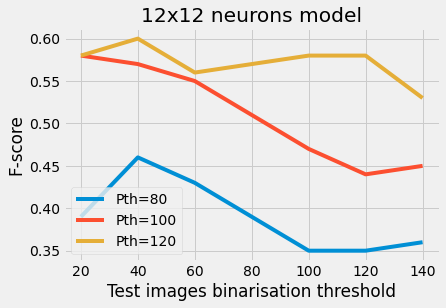

In [273]:
f_fsc=np.array(f_fsc)
plt.plot(f_tth[0:7],f_fsc[0:7],label='Pth=80')
plt.plot(f_tth[7:14],f_fsc[7:14],label='Pth=100')
plt.plot(f_tth[14:21],f_fsc[14:21],label='Pth=120')
plt.xlabel('Test images binarisation threshold')
plt.ylabel('F-score')
plt.title('12x12 neurons model')
plt.legend()

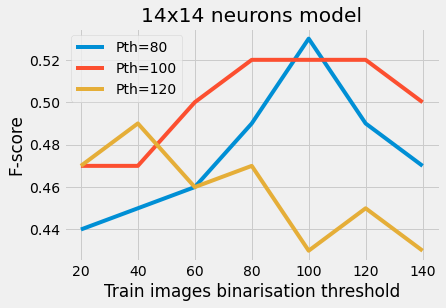

In [274]:
plt.plot(f_tth[21:28],f_fsc[21:28],label='Pth=80')
plt.plot(f_tth[28:35],f_fsc[28:35],label='Pth=100')
plt.plot(f_tth[35:42],f_fsc[35:42],label='Pth=120')
plt.xlabel('Train images binarisation threshold')
plt.ylabel('F-score')
plt.title('14x14 neurons model')
plt.legend()

In [352]:
#Final check
x1,x2,x3,x4=acc_calc(12,120,40,0,1000)
x1,x2,x3,x4=acc_calc(12,120,100,1000,2000) 
x1,x2,x3,x4=acc_calc(12,100,20,1000,2000)
x1,x2,x3,x4=acc_calc(14,80,100,3000,4000)

No of neurons= 12 Pattern threshold= 120 Test images threshold= 40 F_score= 0.6
No of neurons= 12 Pattern threshold= 120 Test images threshold= 100 F_score= 0.58
No of neurons= 12 Pattern threshold= 100 Test images threshold= 20 F_score= 0.58
No of neurons= 14 Pattern threshold= 80 Test images threshold= 100 F_score= 0.53


In [353]:
#Ideal threshold
x1,x2,x3,x4=acc_calc(12,120,40,0,10000)

No of neurons= 12 Pattern threshold= 120 Test images threshold= 40 F_score= 0.6


### Comparison with classical and deep supervised learning methods

Simple one-layer neural network accuracy - 0.926
Convolutional neural network accuracy - 0.996 
Hopfield network accuracy - 0.6

Classical and deep learning networks perform much better in comparison with the Hopfield network as classifiers. Hopfield networks cannot be used for precise classification due to its inefficiency in resolution.
However, the time and data required to train the hopfield network is much lesser. It is more appropriate for tasks which require quick and broad classification. 

### References

Belyaev, M., & Velichko, A. (2020). Classification of handwritten digits using the Hopfield network. IOP Conference Series: Materials Science And Engineering, 862, 052048. doi: 10.1088/1757-899x/862/5/052048

Ghosh, D., & Wan, A. (2021). Deskewing. Retrieved 13 February 2021, from https://fsix.github.io/mnist/Deskewing.html
    
Acknowledgement - Unsung heroes on multiple stack overflow forums. 